# Install and import dependences

In [ ]:
#!pip install --upgrade python-binance tensorflow

In [1]:
from binance.client import Client
from binance import BinanceSocketManager
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, confusion_matrix

# Load data

In [2]:
api_key = "imuSkmeAI4PpxNERZRcnzx6nEkReEhuLedZphxZNphhnUPLR4QH61aXfjnBqUtfH"
api_secret = "56AvdFdOWWoRF20rh6Knq8awDYM145luMDH0XvDMkSD6nffbRwYTCrsxwJmyVLK1"
client = Client(api_key, api_secret)

In [3]:
#Get the exchange info, which contains information about all trading pairs
exchange_info = client.get_exchange_info()

#Extract the symbols of all trading pairs
symbols = [symbol['symbol'] for symbol in exchange_info['symbols'] if "BRL" in symbol['symbol']]

#Filter out only the base cryptocurrencies (e.g., BTC, ETH)
symbols = list(symbol.split(' ')[0] for symbol in symbols)

In [4]:
# Function to fetch historical cryptocurrency data
def fetch_binance_cryptocurrency_data(symbol, start_date, end_date, interval='1d'):
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)

    # Convert data to a Pandas DataFrame
    df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Convert timestamp to datetime

    return df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

database = {}
present_day = dt.date.today()
start_date = '1900-01-01'
end_date = f"{present_day}"
for ticker in symbols:
    data = fetch_binance_cryptocurrency_data(ticker, start_date, end_date)
    database[ticker] = data.close.values.astype(float)

# Model Functions

In [5]:
def model_1(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(16, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [6]:
def model_2(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(12, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [7]:
def model_3(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(8, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

# Other Functions

In [14]:
# Suppress the warning related to TensorFlow tracing
tf.autograph.set_verbosity(0)

def pred_eval(model_function, lb_list: list = [11], epochs: int = 100, ticker_list: list = symbols, print_info: bool = True):
    buy_list = []
    total_loss = 0
    total_sold = 0
    for lb in lb_list:
        pred_status_list, true_status_list = [], []
        last_price_list = []
        pred_1_list, pred_2_list = [], []
        count = 0
        total_last_stock_price, total_gamble_stock_price = 0, 0
        total_pred_stock_price, total_true_stock_price = 0, 0
        total_proft = 0

        for ticker in ticker_list:
            count += 1
            price = database[ticker]
            act_status, last_price, pred1, pred2, true_price1, true_price2, loss = model_function(price, look_back = lb, epochs=epochs, ticker=ticker, plot_graph = False)
            
            pred_status_list.append(act_status)
            last_price_list.append(last_price)
            pred_1_list.append(pred1)
            pred_2_list.append(pred2)
            total_loss += loss

            my_act_status = act_status
            my_gamble = sell_price(last_price, pred1, pred2)
            gamble_proft = my_gamble/last_price
            sold_status = check_sold(my_gamble, true_price1)

            if my_gamble/last_price < 1.001 and my_act_status == True: 
                my_act_status = False
            if my_act_status == False: 
                sold_status = None
                gamble_proft = None
            if sold_status:
                total_sold += 1
            

            if print_info:
                print('{:<2} '.format(count), 
                      '{:<8} -'.format(ticker), 
                      'LastPrice: {:<10}'.format(round(float(last_price), 3)), 
                      '/ Pred1: {:<10}'.format(round(float(pred1), 3)), 
                      '/ Pred2: {:<10}'.format(round(float(pred2), 3)), 
                      '/ TruePrice1: {:<10}'.format(round(float(true_price1), 3)), 
                      '/ TruePrice2: {:<10}'.format(round(float(true_price2), 3)), 
                      '|| ActStatus: {:<1}'.format(act_status), 
                      '/ MyActStatus: {:<1}'.format(my_act_status), 
                      '/ SoldStatus: {:<1}'.format(sold_status if sold_status is not None else ''), 
                      '/ MyGamble: {:<10}'.format(round(float(my_gamble), 3)), 
                      '/ GambleProft: {:<5}'.format(round(float(gamble_proft), 3) if gamble_proft is not None else ''), 
                      '/ TrueProft: {:<5}'.format(round(true_price1/last_price, 3) if gamble_proft is not None else ''),
                      '|| CorrectModel: {:<1}'.format(act_status == ((true_price1 - last_price) > 0)))
                            

            true_proft = true_price1 - last_price
            if act_status:
                total_last_stock_price += last_price
                total_pred_stock_price += pred1
                total_gamble_stock_price += my_gamble
                total_true_stock_price += true_price1
            if true_proft > 0:
                true_status_list.append(True)
            if true_proft <= 0:
                true_status_list.append(False)
                
            if act_status and my_act_status:
                buy = ['{:<8}'.format(ticker), 
                       'LastPrice: {:<11}'.format(round(float(last_price), 5)), 
                       'MyGamble: {:<11}'.format(round(float(my_gamble), 5)), 
                       'TruePrice: {:<11}'.format(round(float(true_price1), 5)),
                       'GambleProft: {:<5}'.format(round(float(gamble_proft), 3) if gamble_proft is not None else ''), 
                       'TrueProft: {:<5}'.format(round(true_price1/last_price, 3) if gamble_proft is not None else ''),
                       'SoldStatus: {:<1}'.format(sold_status if sold_status is not None else ''),
                       'CorrectModel: {:<1}'.format(act_status == ((true_price1 - last_price) > 0))]
                buy_list.append(buy)
                      

        if not total_last_stock_price == 0:
            print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
            print('Gamble proft %:', total_gamble_stock_price / total_last_stock_price)
            print('True proft %:', total_true_stock_price / total_last_stock_price)
        if total_last_stock_price == 0:
            print('\nAll False')

        if len(buy_list) != 0:
            print('\nLook Back:', lb, '/ Total Loss:', total_loss, '/ Sold Portion:', total_sold/len(buy_list), '\n')
        if len(buy_list) == 0:
            print('\nLook Back:', lb, '/ Total Loss:', total_loss, '/ Sold Portion:', '\n') 
        
        for i in buy_list:
            print(i)
    
        index = my_confusion_matrix(true_status_list, pred_status_list)
        if len(index) > 0: 
            print('Wrong Buy_Act List:')
            for i in index:
                print(symbols[i], '\n')

In [9]:
def my_confusion_matrix(true_status: list, pred_status: list):
    cm = confusion_matrix(true_status, pred_status)
    labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    cm = cm.reshape((2, 2))
    
    # Print indices where true and pred statuses are False and True respectively
    false_true_indices = []
    for i in range(len(true_status)):
        if true_status[i] == False and pred_status[i] == True:
            false_true_indices.append(i)
    
    # Calculate accuracy
    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
    print("CM accuracy:", accuracy)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return false_true_indices 

In [10]:
def sell_price(last_value, pred1, pred2, margin = 0.001):
    'Optmize the sell price'
    if pred1 <= last_value and abs(last_value - pred1) <= (pred1*0.0025):
        return last_value
    
    if (pred1 - (pred1*margin)) <= last_value:
        return last_value
    
    if pred2/pred1 >= 1.05:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        if pred1 + (pred1 * margin) <= last_value * 1.02:
            return pred1 + (pred1 * margin)
        else:
            return last_value * 1.02
    
    if pred2/pred1 >= 1.01:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        if pred1 <= last_value * 1.02:
            return pred1
        else: 
            return last_value * 1.02

    else:
        return pred1 - (pred1 * margin)

In [11]:
def check_sold(gamble, true_price, margin = 0.002):
    'Check if the gamble price was sold'
    return gamble <= true_price + (true_price * margin)

# Predictions & Evaluate


Pred proft %: 1.0004431761945003
Gamble proft %: 1.0000660182293906
True proft %: 1.028028416286753

Look Back: 11 / Total Loss: 12403068.855533026 / Sold Portion: 1.0 

['DOGEBRL ', 'LastPrice: 0.8286     ', 'MyGamble: 0.83493    ', 'TruePrice: 0.9016     ', 'GambleProft: 1.008', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.66101    ', 'TruePrice: 3.74       ', 'GambleProft: 1.006', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.4


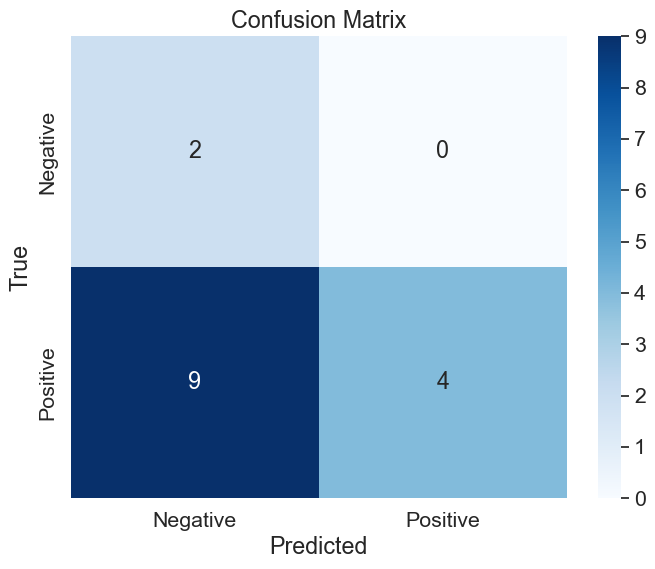


Pred proft %: 1.0038795787250367
Gamble proft %: 1.003041780661753
True proft %: 1.0042468826452624

Look Back: 11 / Total Loss: 1097302.699768357 / Sold Portion: 0.75 

['BTCBRL  ', 'LastPrice: 343050.0   ', 'MyGamble: 344152.503 ', 'TruePrice: 344444.0   ', 'GambleProft: 1.003', 'TrueProft: 1.004', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 444.2      ', 'MyGamble: 446.03241  ', 'TruePrice: 456.6      ', 'GambleProft: 1.004', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00102    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.018', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.5333333333333333


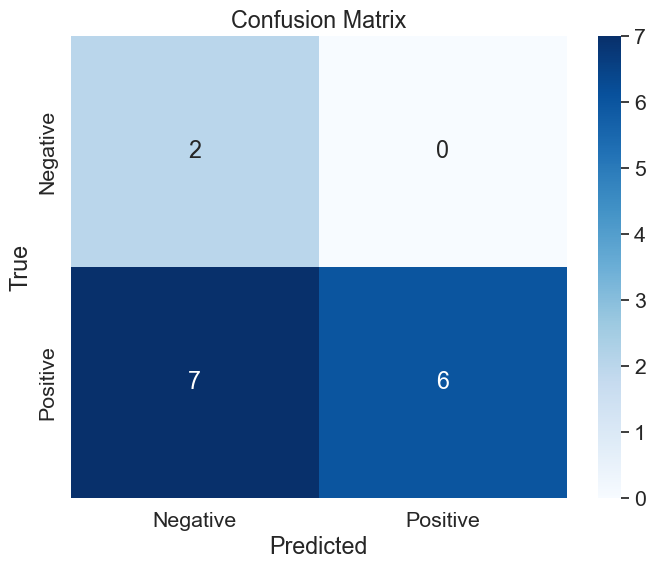


Pred proft %: 0.9988286816728034
Gamble proft %: 1.0005511307387067
True proft %: 1.0067932307076377

Look Back: 11 / Total Loss: 47547167.029973 / Sold Portion: 0.6666666666666666 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2461.11572 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.005', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8286     ', 'MyGamble: 0.83634    ', 'TruePrice: 0.9016     ', 'GambleProft: 1.009', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.02027    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.436', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.4666666666666667


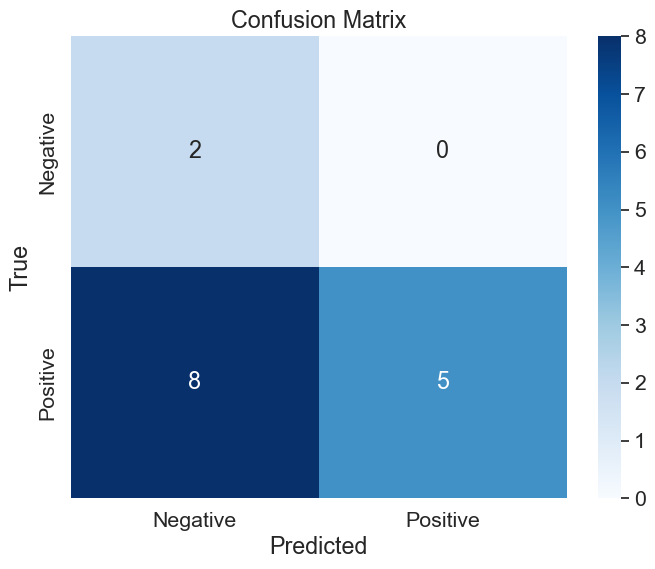


Pred proft %: 1.0075041568322007
Gamble proft %: 1.0077316152203262
True proft %: 1.0093457743058623

Look Back: 11 / Total Loss: 39961034.28855748 / Sold Portion: 0.75 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2472.14551 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.009', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.98112    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.68686    ', 'TruePrice: 3.74       ', 'GambleProft: 1.013', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.01433    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.015', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.5333333333333333


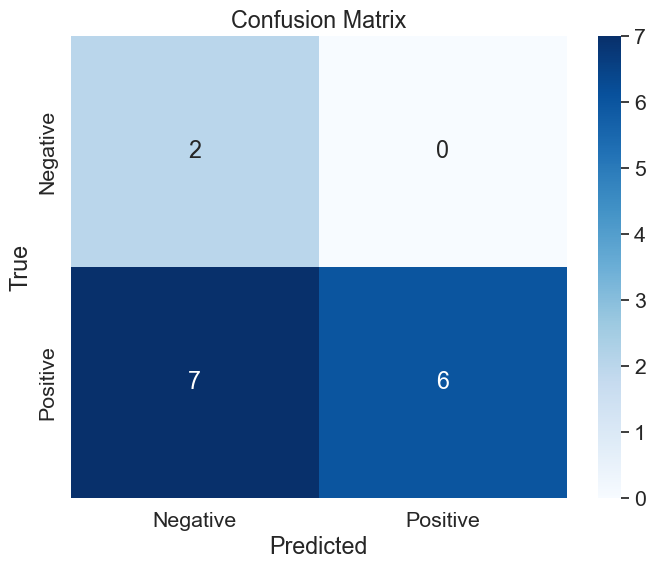

In [15]:
for i in range(4):
    pred_eval(model_3, epochs = 80, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 1.000832098889395
Gamble proft %: 1.0005705394487425
True proft %: 1.0042183381255525

Look Back: 11 / Total Loss: 4044217.856791031 / Sold Portion: 0.75 

['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19763.34961', 'TruePrice: 19691.93   ', 'GambleProft: 1.011', 'TrueProft: 1.007', 'SoldStatus: 0', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.12966    ', 'TruePrice: 3.125      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.64609    ', 'TruePrice: 3.74       ', 'GambleProft: 1.002', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.5333333333333333


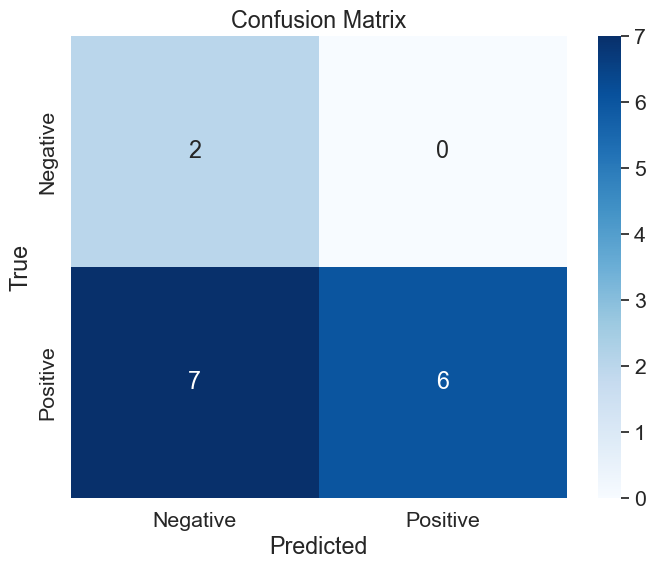


Pred proft %: 1.0004031480540336
Gamble proft %: 1.0000220312092751
True proft %: 1.0057439364415504

Look Back: 11 / Total Loss: 28799229.34267444 / Sold Portion: 0.6666666666666666 

['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.6918     ', 'TruePrice: 3.74       ', 'GambleProft: 1.015', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00102    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.4666666666666667


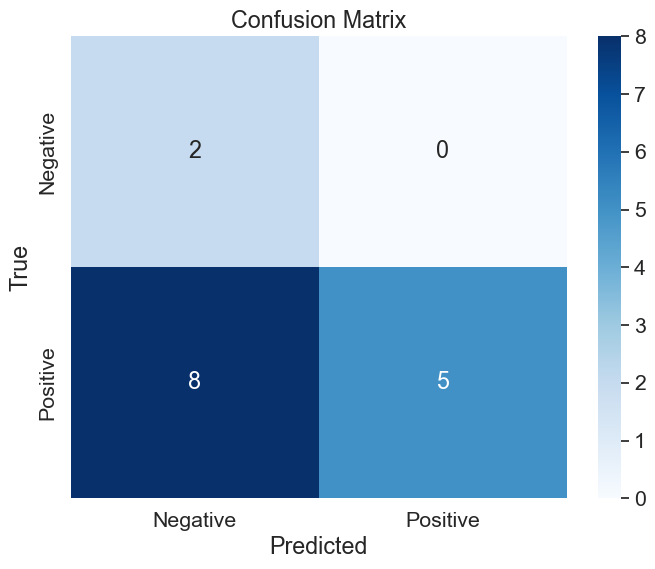


Pred proft %: 1.0001721197077889
Gamble proft %: 1.00000510625577
True proft %: 1.0040667735460507

Look Back: 11 / Total Loss: 1107203.7779011622 / Sold Portion: 0.6666666666666666 

['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.98146    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 100.93365  ', 'TruePrice: 100.73     ', 'GambleProft: 1.018', 'TrueProft: 1.016', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.01427    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.011', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.4666666666666667


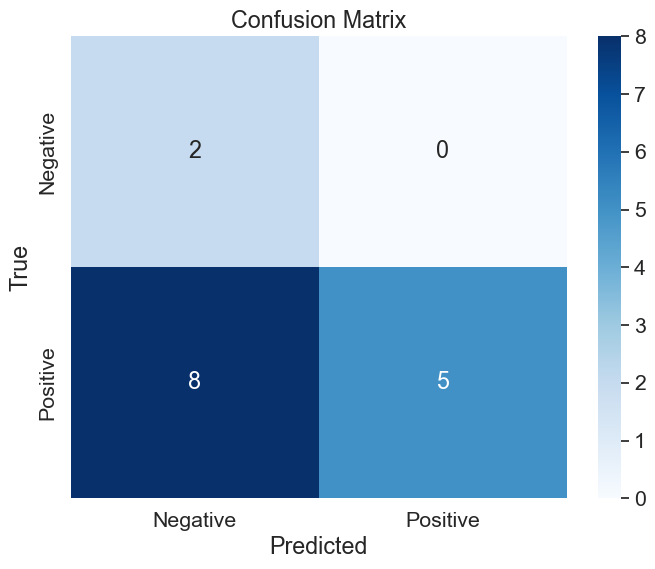


Pred proft %: 1.013167519779818
Gamble proft %: 1.0131408876544166
True proft %: 1.014881155083436

Look Back: 11 / Total Loss: 202120073.6246199 / Sold Portion: 0.75 

['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.13301    ', 'TruePrice: 3.125      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 100.58744  ', 'TruePrice: 100.73     ', 'GambleProft: 1.014', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.68791    ', 'TruePrice: 3.74       ', 'GambleProft: 1.014', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.4666666666666667


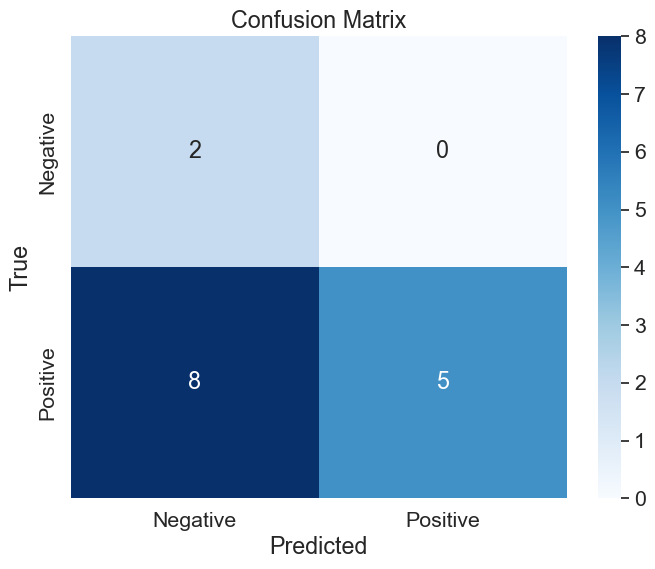

In [16]:
for i in range(4):
    pred_eval(model_3, epochs = 120, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 1.0121828764001426
Gamble proft %: 1.0111706935237423
True proft %: 1.0069679307658934

Look Back: 11 / Total Loss: 119714514621.35745 / Sold Portion: 0.5 

['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19775.46646', 'TruePrice: 19691.93   ', 'GambleProft: 1.011', 'TrueProft: 1.007', 'SoldStatus: 0', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.98477    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.81469   ', 'TruePrice: 100.73     ', 'GambleProft: 1.006', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00111    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.112', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.4


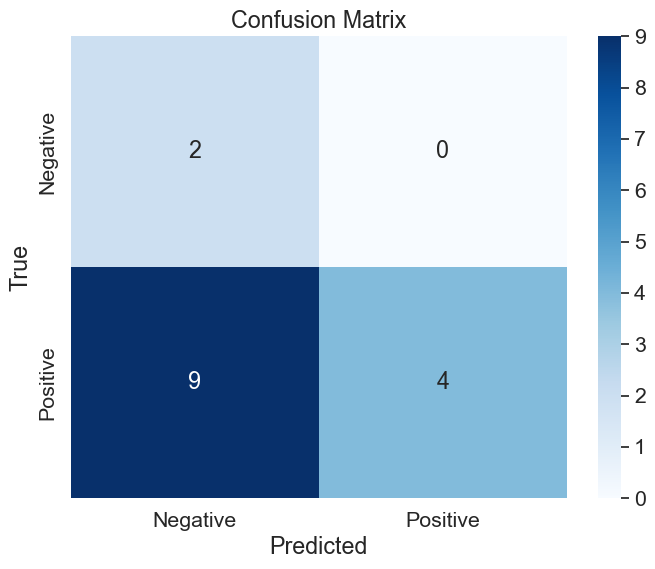


Pred proft %: 1.0004811388925263
Gamble proft %: 1.0000068632004702
True proft %: 1.0069679307658934

Look Back: 11 / Total Loss: 20074313.66561224 / Sold Portion: 0.5 

['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.32491   ', 'TruePrice: 100.73     ', 'GambleProft: 1.001', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00102    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.4


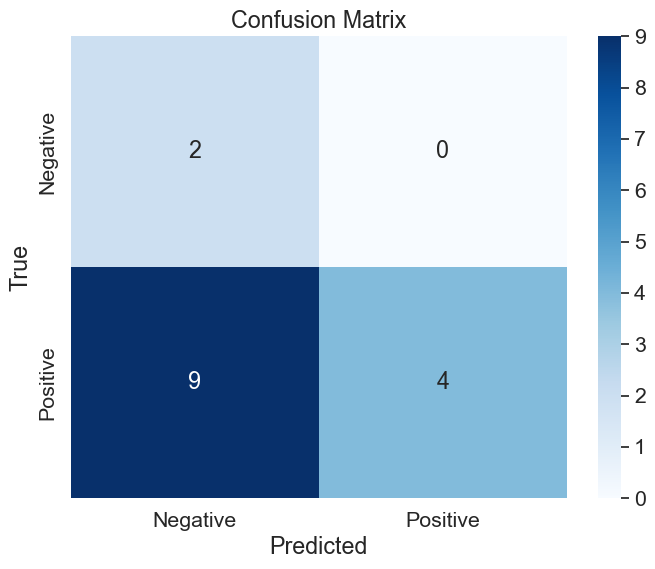


Pred proft %: 1.0012013981010748
Gamble proft %: 1.0023700591767493
True proft %: 1.0250726495032336

Look Back: 11 / Total Loss: 20025144.507536843 / Sold Portion: 0.5 

['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 5.00217    ', 'TruePrice: 4.977      ', 'GambleProft: 1.006', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.13527    ', 'TruePrice: 3.125      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 100.4663   ', 'TruePrice: 100.73     ', 'GambleProft: 1.013', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.5333333333333333


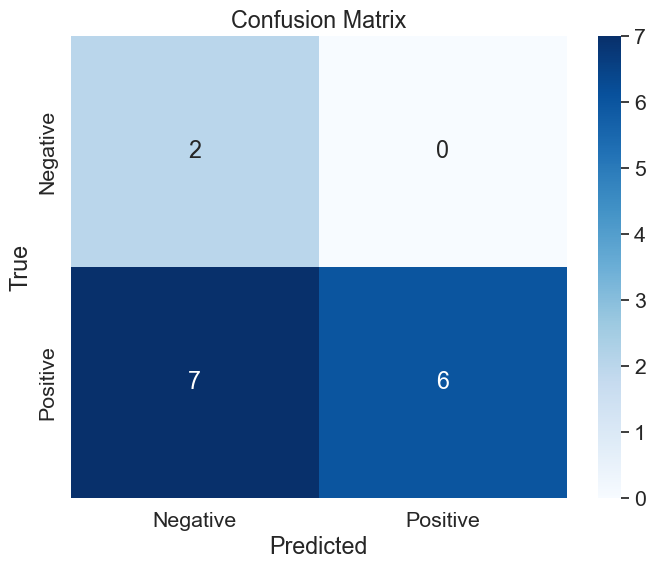


Pred proft %: 1.0005330493426172
Gamble proft %: 1.001179115667709
True proft %: 1.014843958548885

Look Back: 11 / Total Loss: 19211470.36690772 / Sold Portion: 0.6 

['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 5.00363    ', 'TruePrice: 4.977      ', 'GambleProft: 1.006', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.15629    ', 'TruePrice: 3.125      ', 'GambleProft: 1.011', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.7023     ', 'TruePrice: 3.74       ', 'GambleProft: 1.018', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.7746     ', 'TruePrice: 0.7807     ', 'GambleProft: 1.003', 'TrueProft: 1.011', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.01432    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.014', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectMo

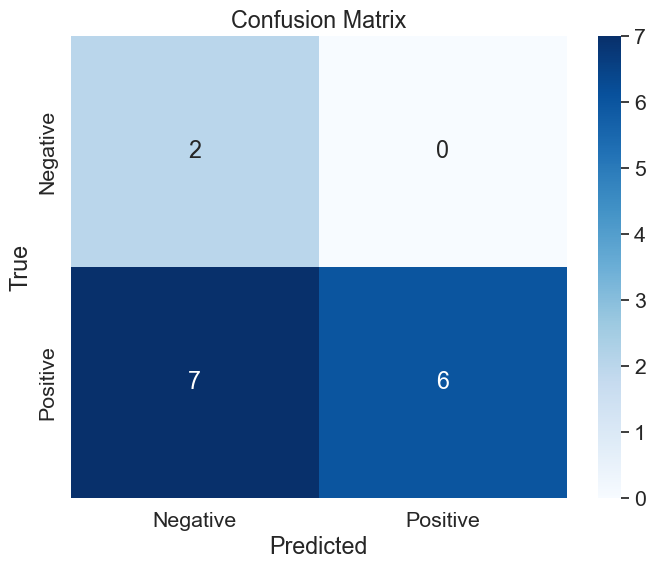

In [17]:
for i in range(4):
    pred_eval(model_3, epochs = 50, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 1.019660079600666
Gamble proft %: 1.018528313970726
True proft %: 1.0160947311439879

Look Back: 11 / Total Loss: 77619623.17158833 / Sold Portion: 0.3333333333333333 

['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.15191    ', 'TruePrice: 3.125      ', 'GambleProft: 1.01 ', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 101.08851  ', 'TruePrice: 100.73     ', 'GambleProft: 1.019', 'TrueProft: 1.016', 'SoldStatus: 0', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8286     ', 'MyGamble: 0.84517    ', 'TruePrice: 0.9016     ', 'GambleProft: 1.02 ', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.67031    ', 'TruePrice: 3.74       ', 'GambleProft: 1.009', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.01549    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.097', 'TrueProft: 1.057', 'SoldStatus:

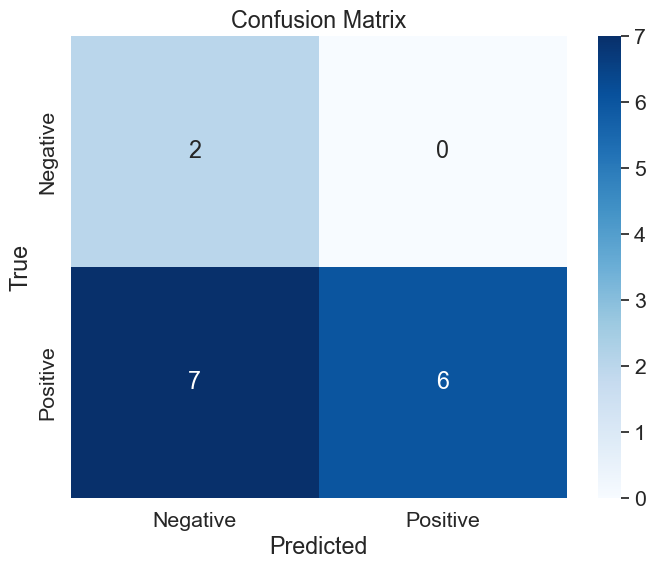


Pred proft %: 1.0062961798349719
Gamble proft %: 1.0052349091580581
True proft %: 1.0123835958224348

Look Back: 11 / Total Loss: 11742299.33340411 / Sold Portion: 0.6666666666666666 

['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.99698    ', 'TruePrice: 4.977      ', 'GambleProft: 1.005', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.65889    ', 'TruePrice: 3.74       ', 'GambleProft: 1.006', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.3333333333333333


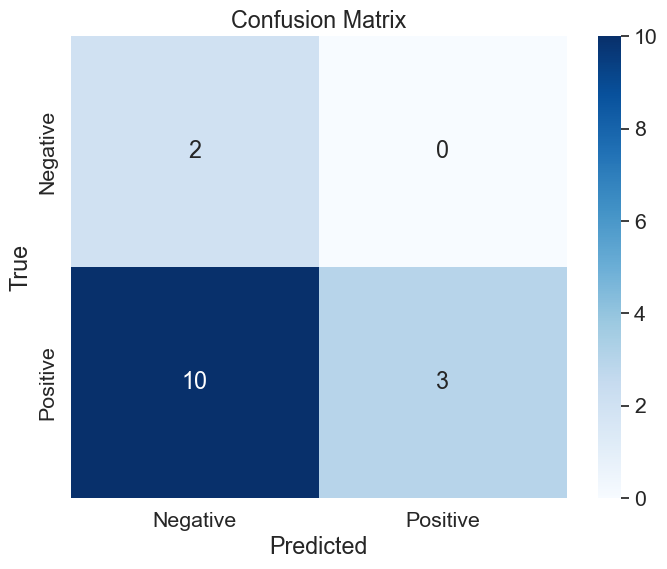


Pred proft %: 1.0086649165494546
Gamble proft %: 1.0078113920661236
True proft %: 1.0042471822905874

Look Back: 11 / Total Loss: 8696276.932977814 / Sold Portion: 0.75 

['BTCBRL  ', 'LastPrice: 343050.0   ', 'MyGamble: 345885.95531', 'TruePrice: 344444.0   ', 'GambleProft: 1.008', 'TrueProft: 1.004', 'SoldStatus: 0', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.64683    ', 'TruePrice: 3.74       ', 'GambleProft: 1.002', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.77389    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.002', 'TrueProft: 1.011', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.01416    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.003', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.5333333333333333


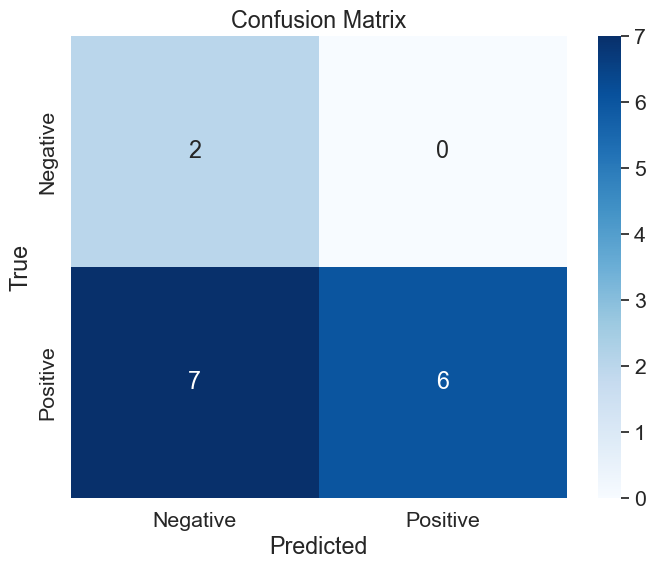


Pred proft %: 1.0057940169887425
Gamble proft %: 1.0047886903564123
True proft %: 1.0069285424114889

Look Back: 11 / Total Loss: 69001349.3009172 / Sold Portion: 0.6666666666666666 

['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19650.14074', 'TruePrice: 19691.93   ', 'GambleProft: 1.005', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.66855    ', 'TruePrice: 3.74       ', 'GambleProft: 1.008', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00118    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.185', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.4


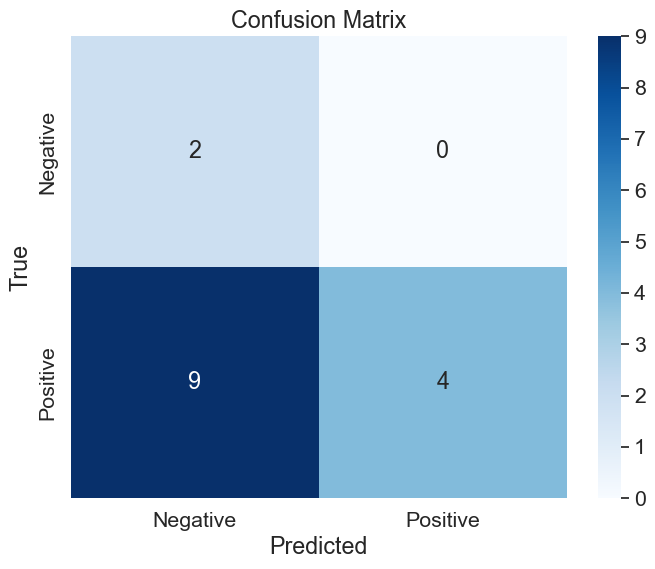

In [18]:
for i in range(4):
    pred_eval(model_3, epochs = 75, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 1.0048201578541962
Gamble proft %: 1.0038729878551302
True proft %: 1.0159740020643266

Look Back: 11 / Total Loss: 98192323.24618796 / Sold Portion: 0.6666666666666666 

['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.58815   ', 'TruePrice: 100.73     ', 'GambleProft: 1.004', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.01426    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.01 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00102    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.4


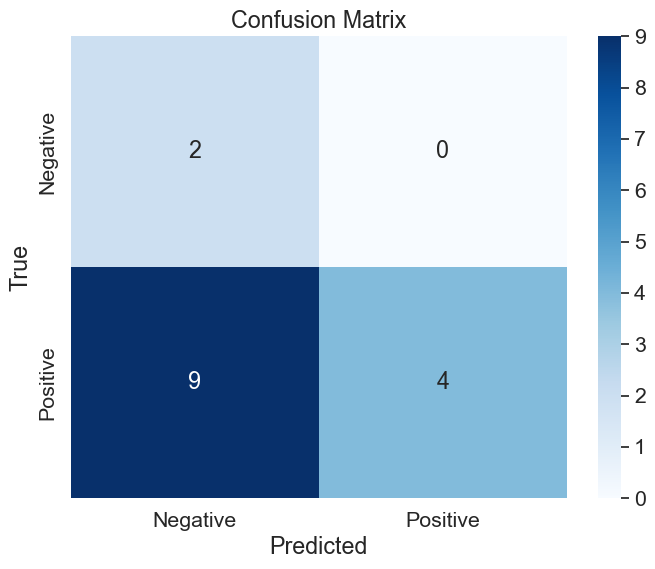


Pred proft %: 0.9999286301174697
Gamble proft %: 1.000000121291271
True proft %: 1.004063772106185

Look Back: 11 / Total Loss: 3715163.0879826727 / Sold Portion: 1.0 

['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.98399    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.66646    ', 'TruePrice: 3.74       ', 'GambleProft: 1.008', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.77418    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.002', 'TrueProft: 1.011', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.4666666666666667


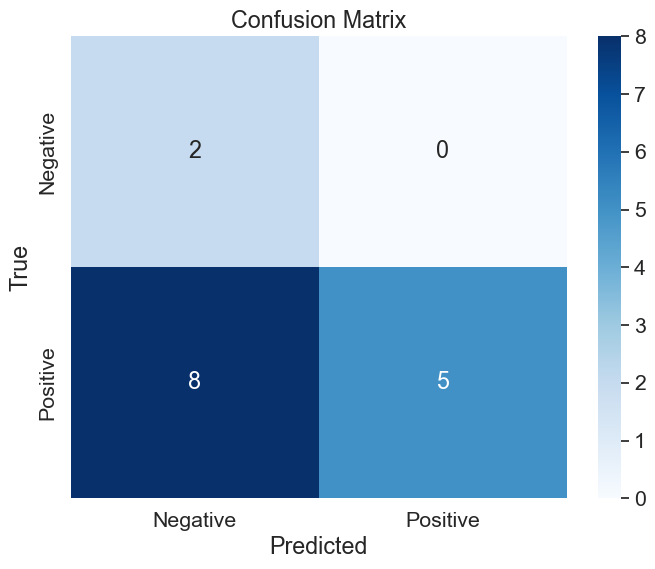


Pred proft %: 1.002561092358453
Gamble proft %: 1.0025950218563082
True proft %: 1.0155317667904946

Look Back: 11 / Total Loss: 119713554794.94885 / Sold Portion: 0.6666666666666666 

['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.33841   ', 'TruePrice: 100.73     ', 'GambleProft: 1.001', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.76429    ', 'TruePrice: 3.74       ', 'GambleProft: 1.035', 'TrueProft: 1.028', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.4


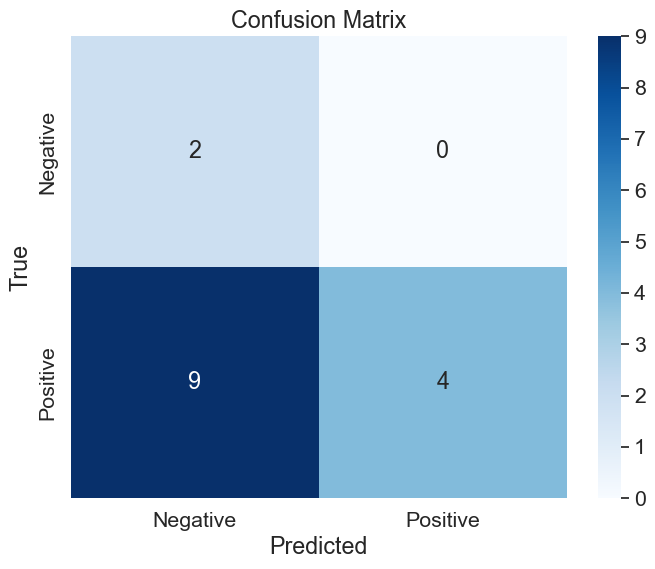


Pred proft %: 1.0154267586746593
Gamble proft %: 1.008292880759248
True proft %: 1.01225910403891

Look Back: 11 / Total Loss: 14160515.922117107 / Sold Portion: 0.75 

['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.71076    ', 'TruePrice: 3.74       ', 'GambleProft: 1.02 ', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.77576    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.004', 'TrueProft: 1.011', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00121    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.209', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.4666666666666667


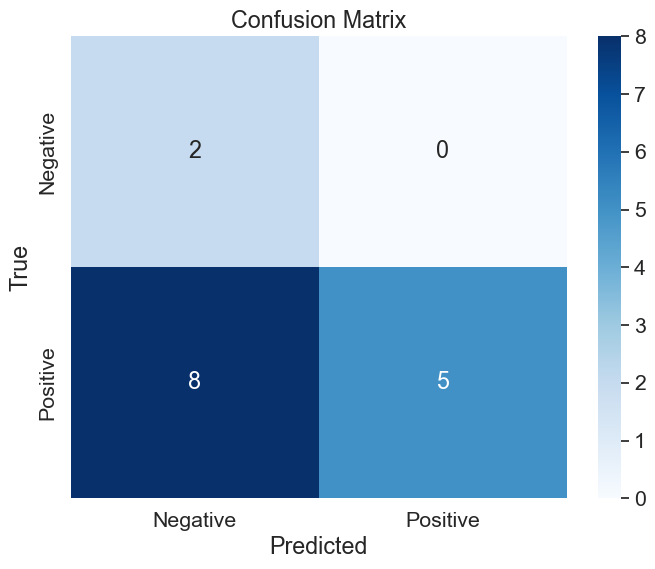

In [19]:
for i in range(4):
    pred_eval(model_3, epochs = 80, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 0.9997759644144006
Gamble proft %: 1.0014159132540654
True proft %: 1.006831564695375

Look Back: 11 / Total Loss: 30965974.910936896 / Sold Portion: 0.75 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2479.68897 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.013', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.74851   ', 'TruePrice: 100.73     ', 'GambleProft: 1.006', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.70327    ', 'TruePrice: 3.74       ', 'GambleProft: 1.018', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.6


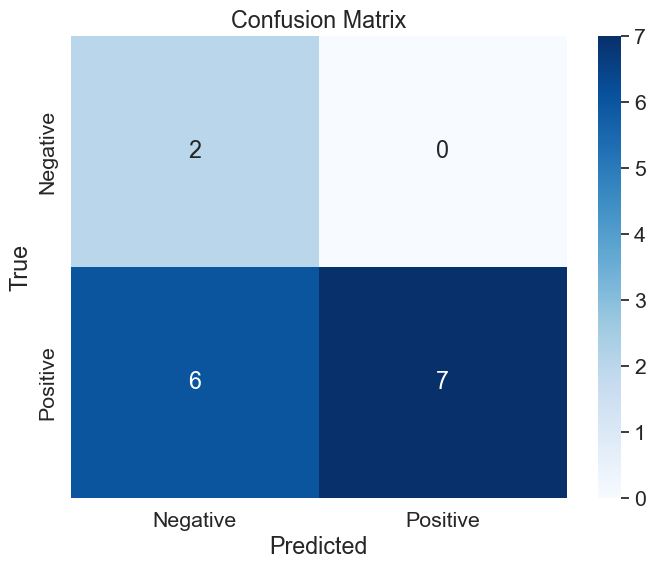


Pred proft %: 0.9999652014968895
Gamble proft %: 1.0
True proft %: 1.0069246166810386

Look Back: 11 / Total Loss: 59514493.49104685 / Sold Portion: 

CM accuracy: 0.26666666666666666


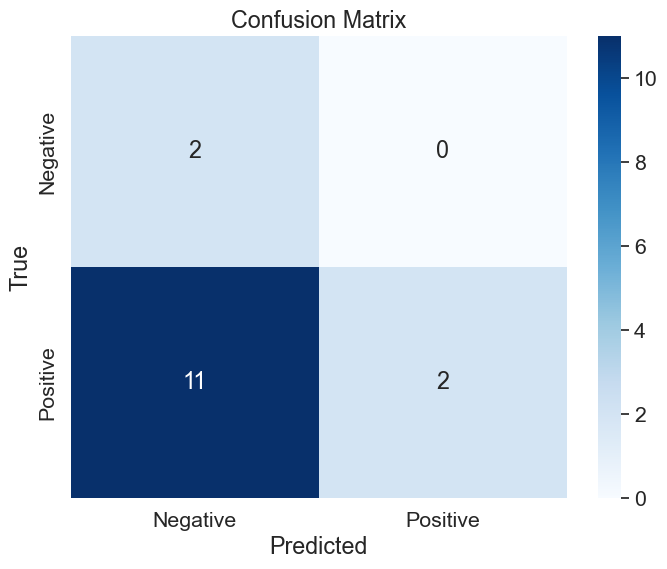


Pred proft %: 0.9981697571630457
Gamble proft %: 1.000137177905802
True proft %: 1.00679435015235

Look Back: 11 / Total Loss: 547808778.3304013 / Sold Portion: 0.6666666666666666 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2451.97876 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.001', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.14009    ', 'TruePrice: 3.125      ', 'GambleProft: 1.006', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.65607    ', 'TruePrice: 3.74       ', 'GambleProft: 1.005', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.77661    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.006', 'TrueProft: 1.011', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.01433    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.015', 'TrueProft: 1.057', 'SoldStatus: 

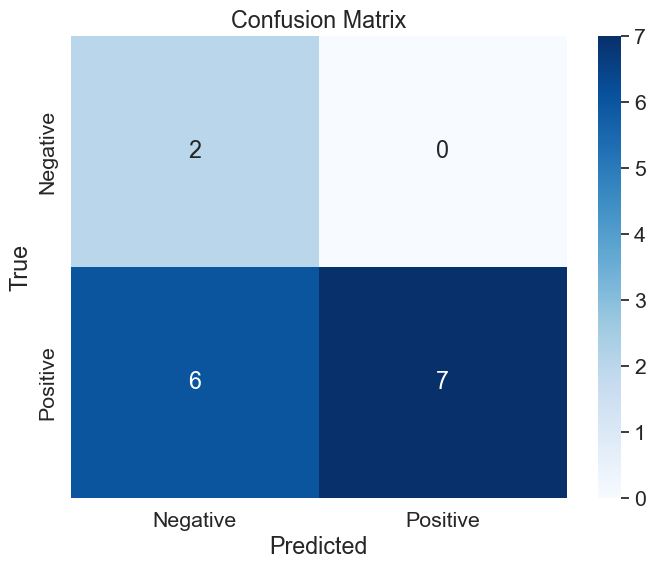


Pred proft %: 1.003355850089753
Gamble proft %: 1.0023770892799924
True proft %: 1.0040785043455298

Look Back: 11 / Total Loss: 741998.2425317015 / Sold Portion: 0.6666666666666666 

['BTCBRL  ', 'LastPrice: 343050.0   ', 'MyGamble: 343870.90988', 'TruePrice: 344444.0   ', 'GambleProft: 1.002', 'TrueProft: 1.004', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.80564   ', 'TruePrice: 100.73     ', 'GambleProft: 1.006', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00105    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.048', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.4666666666666667


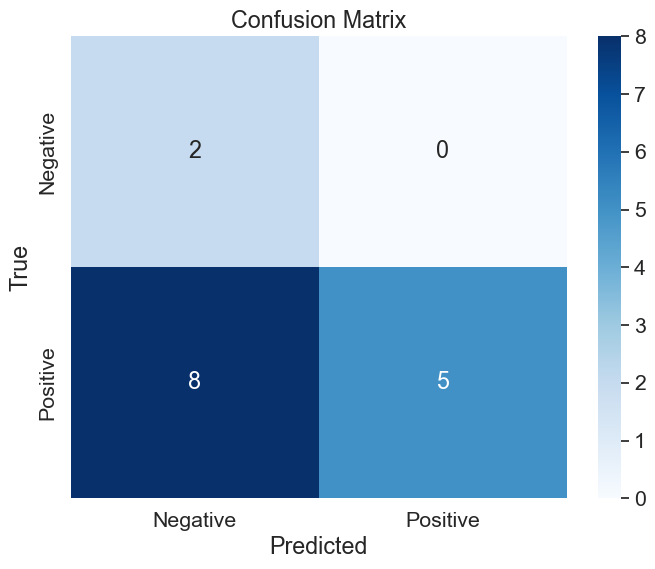

In [20]:
for i in range(4):
    pred_eval(model_3, epochs = 120, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 1.000761138455518
Gamble proft %: 1.0000275491126507
True proft %: 1.0069693951014413

Look Back: 11 / Total Loss: 3857530.0761141726 / Sold Portion: 0.5 

['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.15748    ', 'TruePrice: 3.125      ', 'GambleProft: 1.011', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.69331   ', 'TruePrice: 100.73     ', 'GambleProft: 1.005', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.5333333333333333


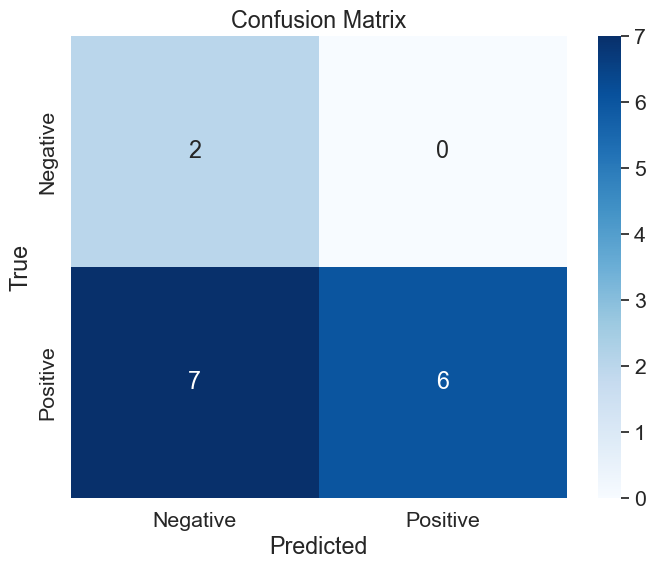


Pred proft %: 1.0125967391090613
Gamble proft %: 1.0125908285422747
True proft %: 1.004109117365597

Look Back: 11 / Total Loss: 9772634.599157844 / Sold Portion: 0.4 

['BTCBRL  ', 'LastPrice: 343050.0   ', 'MyGamble: 347361.3125', 'TruePrice: 344444.0   ', 'GambleProft: 1.013', 'TrueProft: 1.004', 'SoldStatus: 0', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2493.6679  ', 'TruePrice: 2463.0     ', 'GambleProft: 1.018', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 100.23469  ', 'TruePrice: 100.73     ', 'GambleProft: 1.011', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.77995    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.01 ', 'TrueProft: 1.011', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00102    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectM

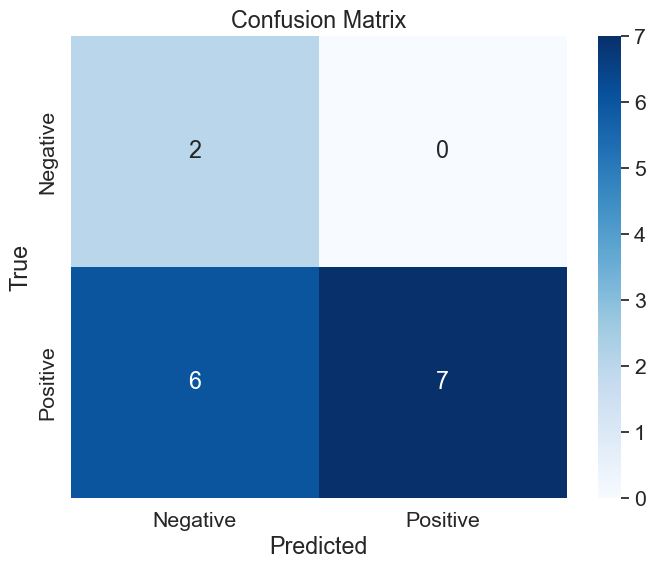


Pred proft %: 1.0044363688252151
Gamble proft %: 1.0034319349812595
True proft %: 1.0042281103385076

Look Back: 11 / Total Loss: 444953.55620085465 / Sold Portion: 0.5714285714285714 

['BTCBRL  ', 'LastPrice: 343050.0   ', 'MyGamble: 344181.91106', 'TruePrice: 344444.0   ', 'GambleProft: 1.003', 'TrueProft: 1.004', 'SoldStatus: 1', 'CorrectModel: 1']
['USDTBRL ', 'LastPrice: 5.036      ', 'MyGamble: 5.09372    ', 'TruePrice: 5.042      ', 'GambleProft: 1.011', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19644.48234', 'TruePrice: 19691.93   ', 'GambleProft: 1.004', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2481.86282 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.013', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.98353    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldSta

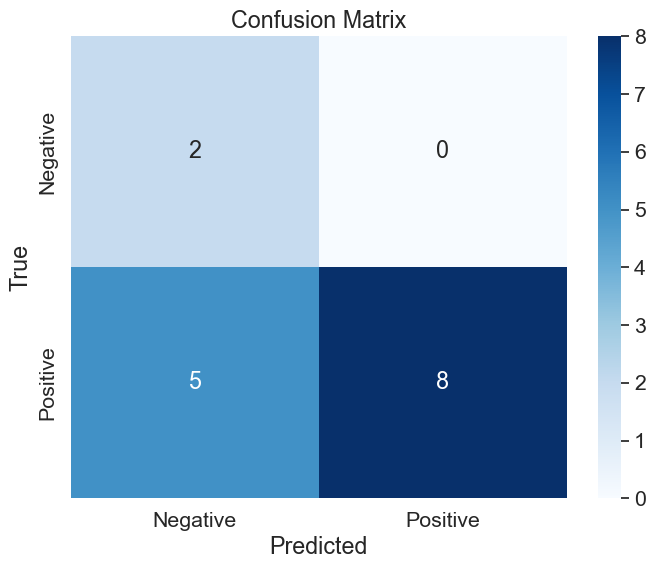


Pred proft %: 1.0016143652789296
Gamble proft %: 1.0006127998553709
True proft %: 1.0040756037835343

Look Back: 11 / Total Loss: 1600392.6524935763 / Sold Portion: 1.0 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2465.41859 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.007', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8286     ', 'MyGamble: 0.84517    ', 'TruePrice: 0.9016     ', 'GambleProft: 1.02 ', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.6473     ', 'TruePrice: 3.74       ', 'GambleProft: 1.003', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.6666666666666666


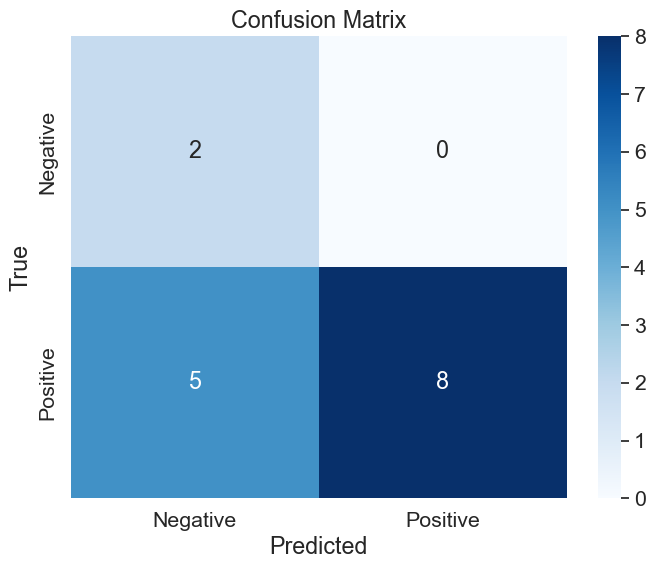

In [21]:
for i in range(4):
    pred_eval(model_3, epochs = 200, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 1.0016417750048152
Gamble proft %: 1.0007257547019135
True proft %: 1.0042501449852441

Look Back: 11 / Total Loss: 742938.2440326123 / Sold Portion: 0.6666666666666666 

['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.14166    ', 'TruePrice: 3.125      ', 'GambleProft: 1.006', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 100.85616  ', 'TruePrice: 100.73     ', 'GambleProft: 1.017', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 444.2      ', 'MyGamble: 446.73163  ', 'TruePrice: 456.6      ', 'GambleProft: 1.006', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.77748    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.007', 'TrueProft: 1.011', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatu

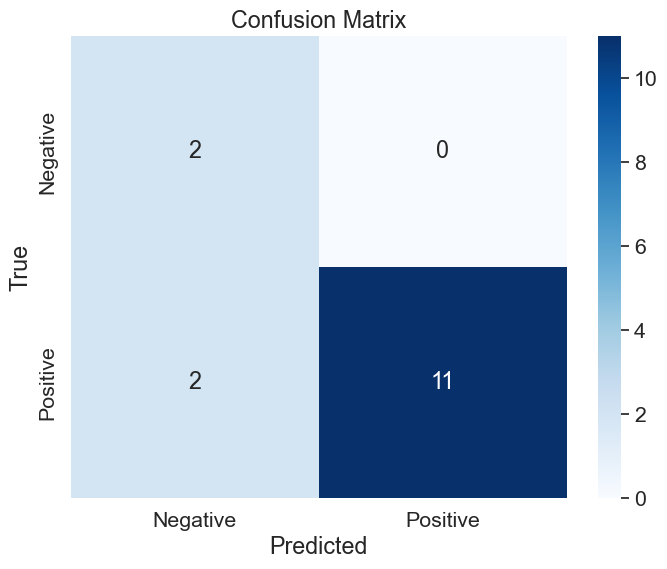


Pred proft %: 1.004540867354098
Gamble proft %: 1.0035365629539812
True proft %: 1.0042213555815507

Look Back: 11 / Total Loss: 1303072.1026873346 / Sold Portion: 0.7142857142857143 

['BTCBRL  ', 'LastPrice: 343050.0   ', 'MyGamble: 344209.9455', 'TruePrice: 344444.0   ', 'GambleProft: 1.003', 'TrueProft: 1.004', 'SoldStatus: 1', 'CorrectModel: 1']
['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19678.09127', 'TruePrice: 19691.93   ', 'GambleProft: 1.006', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.13942    ', 'TruePrice: 3.125      ', 'GambleProft: 1.006', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 100.14542  ', 'TruePrice: 100.73     ', 'GambleProft: 1.01 ', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8286     ', 'MyGamble: 0.84517    ', 'TruePrice: 0.9016     ', 'GambleProft: 1.02 ', 'TrueProft: 1.088', 'SoldStatu

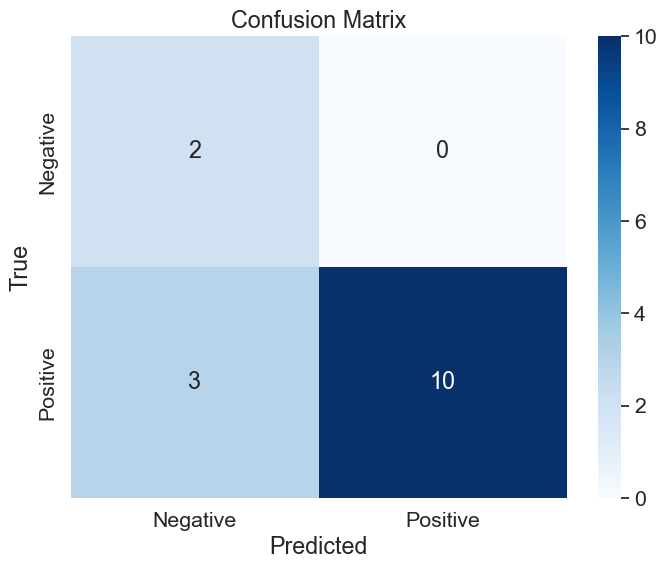


Pred proft %: 1.0017242560245891
Gamble proft %: 1.0007228279281097
True proft %: 1.004066771352966

Look Back: 11 / Total Loss: 5771203.321215288 / Sold Portion: 1.0 

['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 100.12149  ', 'TruePrice: 100.73     ', 'GambleProft: 1.009', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
CM accuracy: 0.4


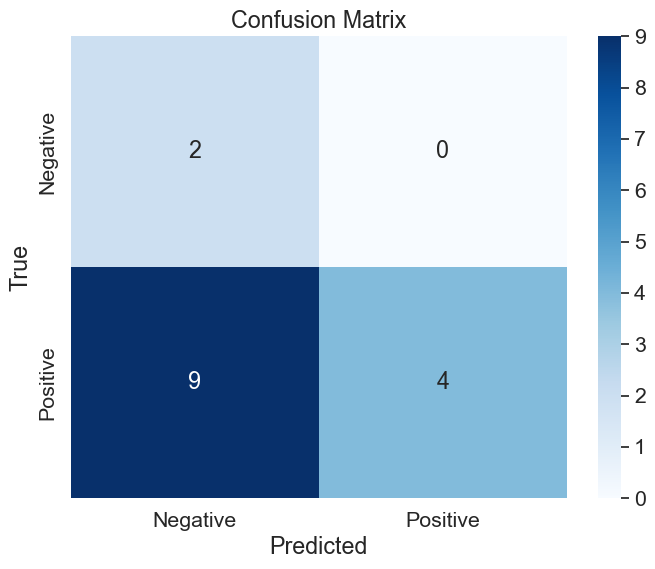


Pred proft %: 1.0096637270923763
Gamble proft %: 1.0096595991756008
True proft %: 1.0250717962947564

Look Back: 11 / Total Loss: 409234289.5431673 / Sold Portion: 0.5 

['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.14046    ', 'TruePrice: 3.125      ', 'GambleProft: 1.006', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.45081   ', 'TruePrice: 100.73     ', 'GambleProft: 1.003', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 444.2      ', 'MyGamble: 449.29449  ', 'TruePrice: 456.6      ', 'GambleProft: 1.011', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00101    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.016', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.5333333333333333


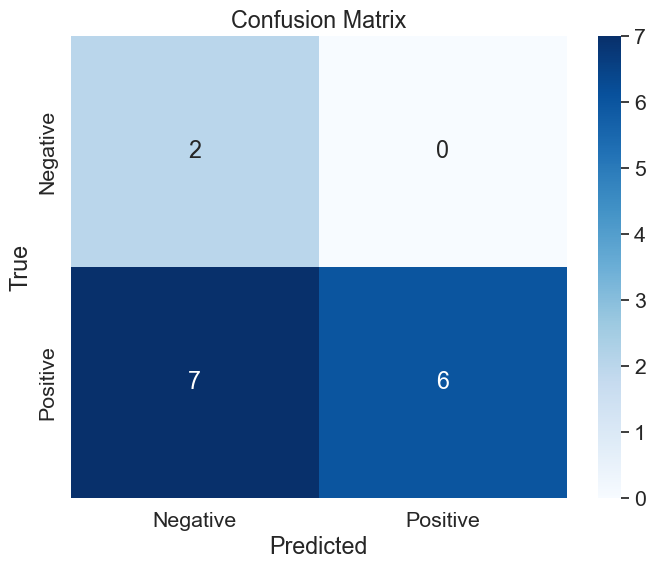

In [22]:
for i in range(4):
    pred_eval(model_3, epochs = 500, lb_list = [11], ticker_list = symbols[:15], print_info = False)


Pred proft %: 1.0053602441146339
Gamble proft %: 1.0056071265790492
True proft %: 1.0089485110973613

Look Back: 11 / Total Loss: 14699292.455440069 / Sold Portion: 0.7142857142857143 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2465.79541 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.007', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.29847   ', 'TruePrice: 100.73     ', 'GambleProft: 1.001', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8286     ', 'MyGamble: 0.83064    ', 'TruePrice: 0.9016     ', 'GambleProft: 1.002', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.62      ', 'MyGamble: 53.82147   ', 'TruePrice: 52.91      ', 'GambleProft: 1.004', 'TrueProft: 0.987', 'SoldStatus: 0', 'CorrectModel: 0']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.77883    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.008', 'TrueProft: 1.011', 'SoldStat

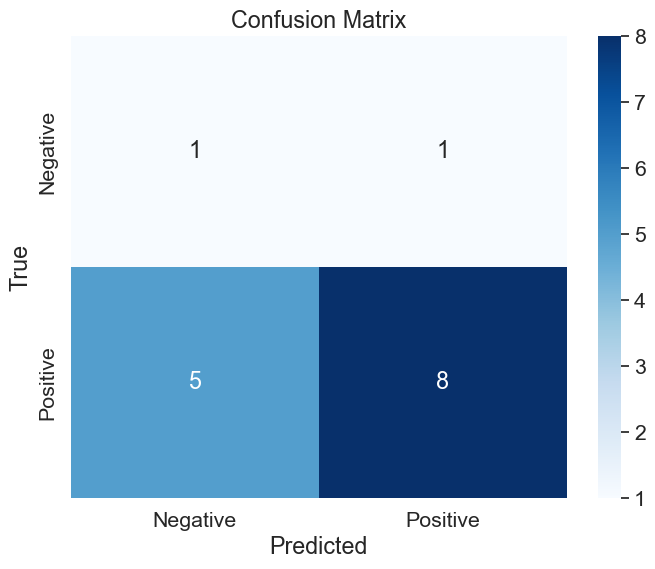

Wrong Buy_Act List:
DOTBRL 



In [ ]:
for i in range(4):
    pred_eval(model_3, epochs = 2500, lb_list = [11], ticker_list = symbols[:15], print_info = False)

# Make a dataframe and save results

In [70]:
import threading
import multiprocessing
import os

# Function to execute in threads or processes
def your_function():
    pred_eval(model_1, epochs = 5000, lb_list = [11], ticker_list = symbols[:3])

def run_multithreading():
    num_threads = os.cpu_count()  # Use all available CPU cores
    threads = []
    for _ in range(num_threads):
        thread = threading.Thread(target=your_function)
        thread.start()
        threads.append(thread)
    for thread in threads:
        thread.join()

def run_multiprocessing():
    num_processes = os.cpu_count()  # Use all available CPU cores
    processes = []
    for _ in range(num_processes):
        process = multiprocessing.Process(target=your_function)
        process.start()
        processes.append(process)
    for process in processes:
        process.join()
        
your_function()

KeyboardInterrupt: 

In [ ]:
#csv_file = df.to_csv(f"Prediction_{present_day}.csv",index=False)

In [ ]:
dic = {"Ticker":[],"Act":[],"LastPrice":[],"Pred1":[],"Pred2":[]}
for ticker, status, last_price, pred_1, pred_2 in zip(symbols, pred_status_list, last_price_list, pred_1_list, pred_2_list):
    dic["Ticker"].append(ticker)
    dic["Act"].append(status)
    dic["LastPrice"].append(last_price)
    dic["Pred1"].append(pred_1)
    dic["Pred2"].append(pred_2)
df = pd.DataFrame(dic)
display(df)
display(df.loc[df["Act"]==True])

In [ ]:
pred_status_list, true_status_list = [], []
last_price_list = []
pred_1_list, pred_2_list = [], []
total_last_stock_price, total_pred_stock_price, total_true_stock_price = 0, 0, 0

for ticker in symbols:
    price = database[ticker]
    status, last_price, pred1, pred2, true_price1, true_price2 = predict(price, ticker=ticker)
    pred_status_list.append(status)
    last_price_list.append(last_price)
    pred_1_list.append(pred1)
    pred_2_list.append(pred2)
    pred_proft, true_proft = pred1 - last_price, true_price1 - last_price
    if status:
        total_last_stock_price += last_price
        total_pred_stock_price += pred1
        total_true_stock_price += true_price1
    if true_proft > 0:
        true_status_list.append(True)
    if true_proft <= 0:
        true_status_list.append(False)

print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
print('\nTrue proft %:', total_true_stock_price / total_last_stock_price)
my_confusion_matrix(true_status_list, pred_status_list)

In [50]:
max_crypto = ''
min_crypto = ''
max_max_value = 0
min_max_value = 1e3
for ticker in symbols:
    price = database[ticker]
    max_value = max(price)
    if max_value > max_max_value:
        max_max_value = max_value
        max_crypto = ticker
    if max_value < min_max_value:
        min_max_value = max_value
        min_crypto = ticker
        
print('MaxCrypto:', max_crypto, max_max_value)
print('MinCrypto:', min_crypto, min_max_value)

MaxCrypto: BTCBRL 376520.0
MinCrypto: SHIBBRL 0.00044702
